<a href="https://colab.research.google.com/github/tiq015UCSD/Email-Delivery-Experiment-on-Account-Funding-Rate-Improvement/blob/main/Tian_Qin_Email_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# displays output inline
%matplotlib inline

In [3]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

## 1. Email List

In [4]:
# hard code Email lists. Email ID is the index of the Email in the list
PO_number_list = ['ml_funding_enables_investing',
                  'ml_investing_starts_here',
                  'ml_explore_the_app_investing',
                  'ml_funding_faq',
                  'ml_user_clustering_emails_fracs',
                  'ml_funding_is_safe',
                  'ml_picking_an_investment', 
                  'ml_investing_101',
                  'ml_diversified_portfolio',
                  'ml_explore_the_app_list']

## 2. User Segment Information

In [5]:
segment_group_init_df = pd.read_csv('/content/drive/MyDrive/Project/prj1/sample_segment_groups.csv')
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df

,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act
5,5,False,True,True,True,136513,link-20D_Act-5D_Act
6,6,True,False,False,False,814827,6M_App
7,7,True,False,True,False,218938,6M_App-20D_Act
8,8,True,False,True,True,233445,6M_App-20D_Act-5D_Act
9,9,True,True,False,False,127008,6M_App-link


## 3. Sampled Users with Email Delivery Orders for the Experiment

In [6]:
sample_exp_df = pd.read_csv('/content/drive/MyDrive/Project/prj1/sample_uuid_email_order.csv')
sample_exp_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [7]:
sample_exp_df.shape

(480000, 13)

## Load Email Events

In [8]:
email_event_summary_df = pd.read_csv('/content/drive/MyDrive/Project/prj1/email_events.csv')
email_event_summary_df.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [9]:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

# Load Current User Status

In [10]:
user_event_df = pd.read_csv('/content/drive/MyDrive/Project/prj1/user_events.csv')
user_event_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,...,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,...,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [11]:
user_event_df.shape

(480000, 22)

# Load the Current Status for Control Groups.

They have the same segmentation rules in the beginning of the experiment.  
These users did not received any Emails during the experiment.

In [12]:
fund_control_df = pd.read_csv('/content/drive/MyDrive/Project/prj1/control_groups_rate.csv')
fund_control_df

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000
5,6M_App-link-20D_Act_D,7883,291,0.036915,7883,1.000000
6,6M_App-link_D,87008,1072,0.012321,87008,1.000000
7,6M_App_D,774827,8675,0.011196,10086,0.013017
8,ML_unfund_exp_control_D,1000000,4443,0.004443,5461,0.005461
9,link-20D_Act-5D_Act_D,96513,3645,0.037767,96513,1.000000


# Calculate Metrics for Treatment Groups

## 1. Email Open Rate

In [13]:
# Number of email delivered for each user segment
num_delivered_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for i in PO_number_list:
    num_delivered_df[i] = num_delivered_df[i].notnull()
    
num_delivered_df = num_delivered_df.groupby('group_name').sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
num_delivered_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249
1,20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294
2,20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042
3,20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094
4,6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273


In [15]:
# Number of email opened for each user segment
num_open_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for i in PO_number_list:
    num_open_df[i] = num_open_df[i] == 'open'
    
num_open_df = num_open_df.groupby('group_name').sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
num_open_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290
1,20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879
2,20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520
3,20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170
4,6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590


In [17]:
# Email open rate for each user segment
open_rate_df = num_open_df
for i in PO_number_list:
    open_rate_df[i] = num_open_df[i]/num_delivered_df[i]

In [18]:
open_rate_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271


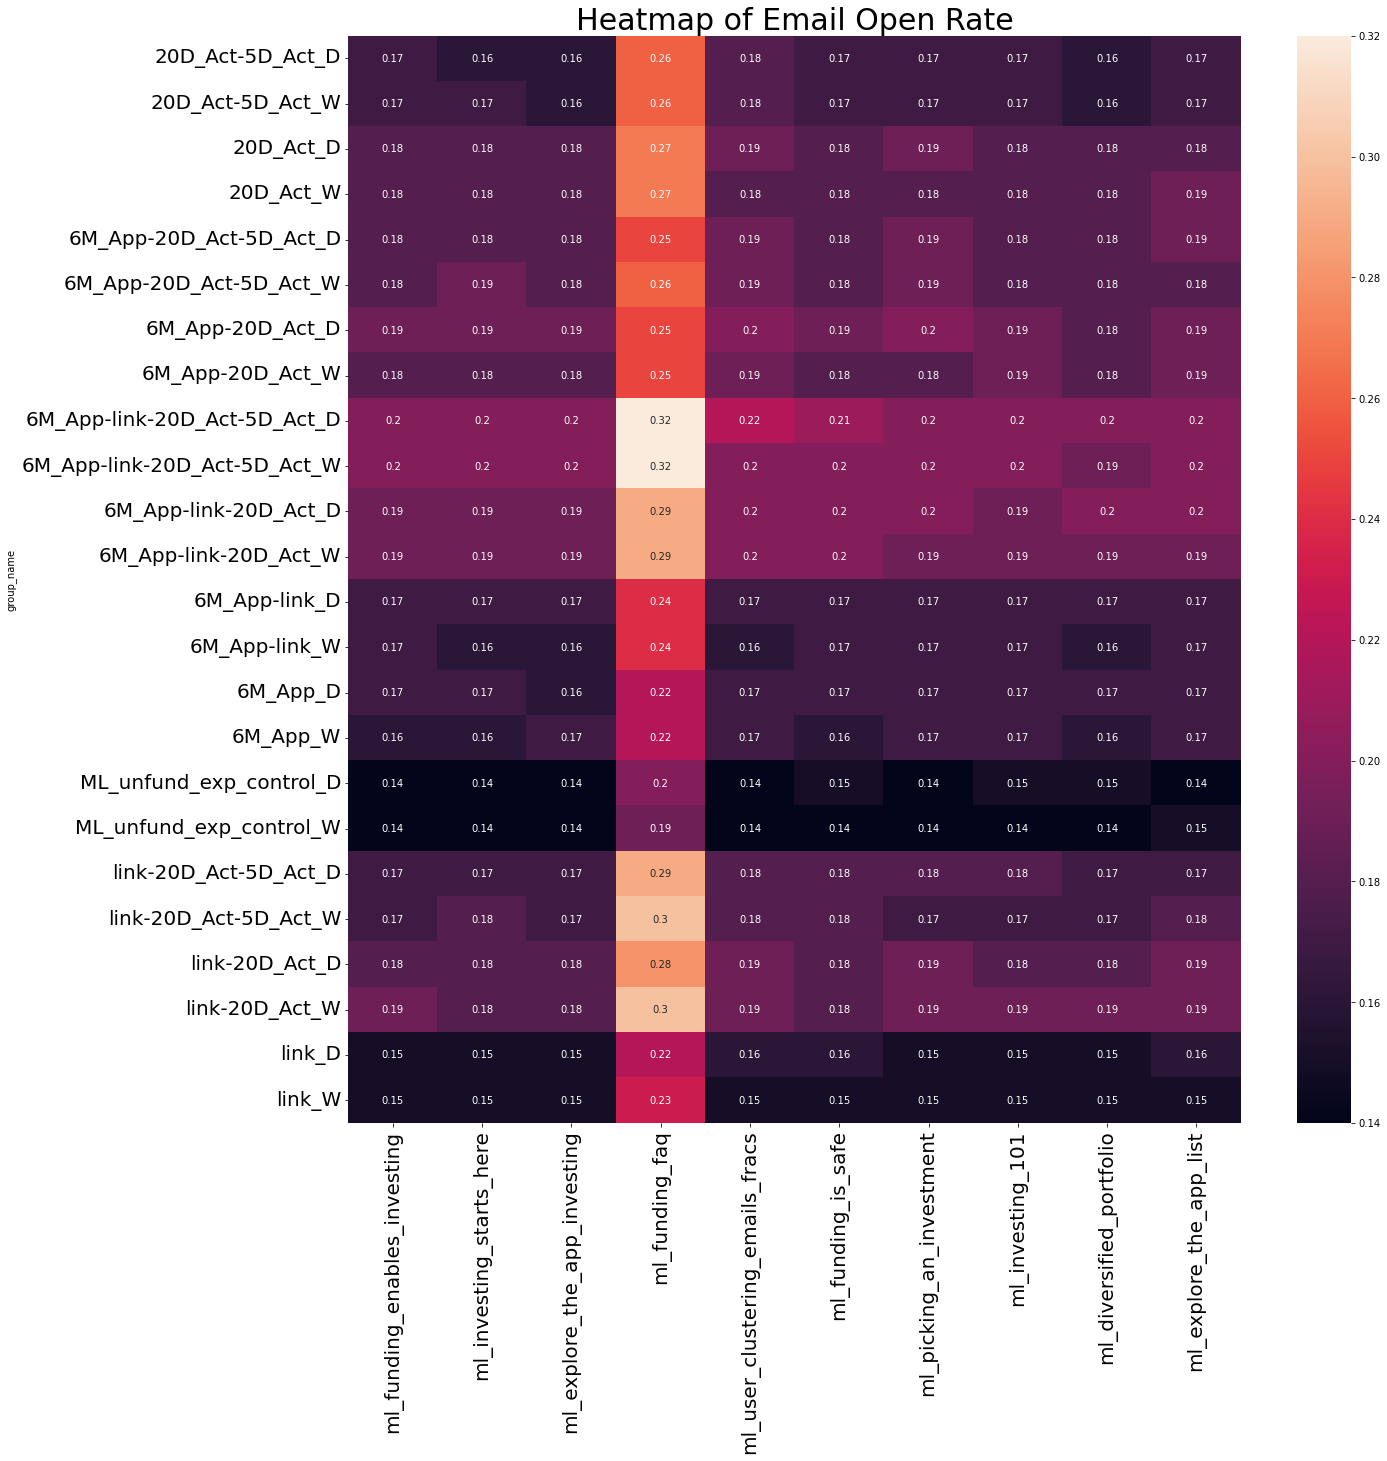

In [19]:
# Heatmap of Email open rate
index_group_name_df = open_rate_df.round(2).set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(index_group_name_df, annot=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email Open Rate', fontsize=30) 
plt.show()

As shown in the heatmap, the email tpye 'ml_funding_faq' is most effective which has highest open rate, and each user segments '6M_App-link-20D_Act-5D_Act_D' and '6M_App-link-20D_Act-5D_Act_W' have best performance.    
Besides, the heatmap does not show significant different between sending the email daily and sending twice a week.

## 2. Correlation Analysis on Open Rate


In [20]:
# Create columns to identify the email sending frequence for each user segment
open_rate_df_comb = open_rate_df.copy()
open_rate_df_comb['daily'] = open_rate_df_comb['group_name'].str.contains('_D')
open_rate_df_comb['twice_W'] = open_rate_df_comb['group_name'].str.contains('_W')
open_rate_df_comb['group_name'] = open_rate_df_comb['group_name'].str.strip('_D')
open_rate_df_comb['group_name'] = open_rate_df_comb['group_name'].str.strip('_W')

# Combine the open rate table with segement table
open_rate_df_comb = pd.merge(open_rate_df_comb, segment_group_init_df, on='group_name', how='left')

In [21]:
open_rate_df_comb.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_W,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid
0,20D_Act-5D_Act,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,True,False,2,False,False,True,True,409786
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,True,2,False,False,True,True,409786
2,20D_Act,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,True,False,1,False,False,True,False,314921
3,20D_Act,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,True,1,False,False,True,False,314921
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,True,False,8,True,False,True,True,233445


In [22]:
# Transform the dataframe to find the open rate of each user segment for each email type
open_rate_df_comb_temp = open_rate_df_comb.copy()
open_rate_df_comb_temp[PO_number_list] = False

open_rate_df_comb_TF = pd.DataFrame()
for i in PO_number_list:
    temp = open_rate_df_comb_temp.copy()
    temp[i] = True
    temp['open_rate'] = open_rate_df_comb[i]
    open_rate_df_comb_TF = pd.concat([open_rate_df_comb_TF, temp])

# Reset index, and assign a new index for each row
open_rate_df_comb_TF = open_rate_df_comb_TF.reset_index()
open_rate_df_comb_TF = open_rate_df_comb_TF.drop(columns = ['index'])


In [23]:
open_rate_df_comb_TF.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_W,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,open_rate
0,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,2,False,False,True,True,409786,0.165939
1,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,True,2,False,False,True,True,409786,0.165001
2,20D_Act,True,False,False,False,False,False,False,False,False,False,True,False,1,False,False,True,False,314921,0.181723
3,20D_Act,True,False,False,False,False,False,False,False,False,False,False,True,1,False,False,True,False,314921,0.175677
4,6M_App-20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,8,True,False,True,True,233445,0.179627


In [24]:
# Calculate the correlation between the open_rate and email types with user segment features
open_rate_corr = open_rate_df_comb_TF.corr()

open_rate_corr.sort_values(by=['open_rate'], ascending =False)['open_rate']

open_rate                          1.000000
ml_funding_faq                     0.793531
recent_activity_flag(20days)       0.450146
group_id                           0.364588
approved_within6M_flag             0.241516
5day_trade_flag                    0.172443
link_flag                          0.160358
daily                              0.026641
ml_user_clustering_emails_fracs   -0.025562
twice_W                           -0.026641
ml_picking_an_investment          -0.065907
ml_explore_the_app_list           -0.074458
ml_funding_is_safe                -0.082867
ml_investing_101                  -0.090776
ml_investing_starts_here          -0.098976
ml_funding_enables_investing      -0.114963
ml_explore_the_app_investing      -0.117040
ml_diversified_portfolio          -0.122984
user_uuid                         -0.413757
Name: open_rate, dtype: float64

Email type with 'ml_funding_faq' is most correlated with open rate.

## 3. Link, Funding Rates for Treatment Groups

In [25]:
# Number of users who received emails for each treatment groups
n_users_received_email_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].nunique().to_frame('n_users_received_email').reset_index()

In [26]:
n_users_received_email_df.head()

,group_name,n_users_received_email
0,20D_Act-5D_Act_D,18918
1,20D_Act-5D_Act_W,18966
2,20D_Act_D,18606
3,20D_Act_W,18711
4,6M_App-20D_Act-5D_Act_D,18927


In [27]:
# Funding Rate
n_user_funding_df = user_event_df[user_event_df['first_funded_at'].notnull()].groupby('group_name')['user_uuid'].nunique().to_frame('n_user_funding').reset_index()
link_funding_inf_df = n_users_received_email_df.copy()
link_funding_inf_df['n_user_funding'] = n_user_funding_df['n_user_funding']
link_funding_inf_df['funding_rate'] = link_funding_inf_df['n_user_funding'] / link_funding_inf_df['n_users_received_email']

In [28]:
link_funding_inf_df.head()

,group_name,n_users_received_email,n_user_funding,funding_rate
0,20D_Act-5D_Act_D,18918,451,0.023840
1,20D_Act-5D_Act_W,18966,450,0.023727
2,20D_Act_D,18606,357,0.019187
3,20D_Act_W,18711,310,0.016568
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519


In [29]:
# Link Rate
n_user_link_df = user_event_df[user_event_df['first_linked_bank_account_at'].notnull()].groupby('group_name')['user_uuid'].nunique().to_frame('n_user_link').reset_index()
link_funding_inf_df['n_user_link'] = n_user_link_df['n_user_link']
link_funding_inf_df['link_rate'] = link_funding_inf_df['n_user_link'] / link_funding_inf_df['n_users_received_email']

In [30]:
link_funding_inf_df.head()

,group_name,n_users_received_email,n_user_funding,funding_rate,n_user_link,link_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263
2,20D_Act_D,18606,357,0.019187,460,0.024723
3,20D_Act_W,18711,310,0.016568,395,0.021111
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403


# A/B Testing for Link and Funding Rate on Treatment and Control Groups

1. Null hypothesis (H_0): funding rate in treatment = funding rate in control / link rate in treatmemt = link rate in control  

2. Alternative hypothesis (H_1): funding rate in treatment > funding rate in control / link rate in treatmemt > link rate in control   

3. Method: Two sample one tailed proportional Z test.

In [31]:
# Load control group whose users never received any email before
control_df = pd.read_csv('//content/drive/MyDrive/Project/prj1/control_groups_rate.csv')

In [32]:
control_df.head(10)

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000
5,6M_App-link-20D_Act_D,7883,291,0.036915,7883,1.000000
6,6M_App-link_D,87008,1072,0.012321,87008,1.000000
7,6M_App_D,774827,8675,0.011196,10086,0.013017
8,ML_unfund_exp_control_D,1000000,4443,0.004443,5461,0.005461
9,link-20D_Act-5D_Act_D,96513,3645,0.037767,96513,1.000000


In [33]:
# Merge the treatment and control groups
merge_contr_treat = pd.merge(link_funding_inf_df, control_df, how='left', on='group_name')
merge_contr_treat = merge_contr_treat.fillna(method='ffill')

In [34]:
# Calculated the difference between treatment and control groups
merge_contr_treat['diff_funding_rate'] = merge_contr_treat['funding_rate'] - merge_contr_treat['funding_rate_in_control']
merge_contr_treat['diff_link_rate'] = merge_contr_treat['link_rate'] - merge_contr_treat['link_rate_in_control']

In [35]:
merge_contr_treat.head()

,group_name,n_users_received_email,n_user_funding,funding_rate,n_user_link,link_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,diff_funding_rate,diff_link_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,369786.0,7802.0,0.021099,9899.0,0.026770,0.002741,0.004206
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,369786.0,7802.0,0.021099,9899.0,0.026770,0.002628,0.002493
2,20D_Act_D,18606,357,0.019187,460,0.024723,274921.0,4053.0,0.014742,5143.0,0.018707,0.004445,0.006016
3,20D_Act_W,18711,310,0.016568,395,0.021111,274921.0,4053.0,0.014742,5143.0,0.018707,0.001825,0.002403
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,193445.0,11556.0,0.059738,13396.0,0.069250,0.006781,0.008153


In [36]:
# Create a function to calculate the P-value for each row
def funding_pval(df):
    stat, p_value = proportions_ztest(count=np.array([df['n_user_funding'], df['num_funded_in_control']]), nobs=np.array([df['n_users_received_email'], df['num_users_in_control']]), alternative='larger')
    return p_value

def link_pval(df):
    stat, p_value = proportions_ztest(count=np.array([df['n_user_link'], df['num_link_in_control']]), nobs=np.array([df['n_users_received_email'], df['num_users_in_control']]), alternative='larger')
    return p_value

In [37]:
# Compare the P-value with significance level which set as 0.05
merge_contr_treat['p_val_funding'] = merge_contr_treat.apply(funding_pval, axis=1)
merge_contr_treat['significant_funding'] = merge_contr_treat['p_val_funding'] <= 0.05

merge_contr_treat['p_val_link'] = merge_contr_treat.apply(link_pval, axis=1)
merge_contr_treat['significant_link'] = merge_contr_treat['p_val_link'] <= 0.05

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/proportion.py:860: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


In [38]:
merge_contr_treat

,group_name,n_users_received_email,n_user_funding,funding_rate,n_user_link,link_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,diff_funding_rate,diff_link_rate,p_val_funding,significant_funding,p_val_link,significant_link
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,369786.0,7802.0,0.021099,9899.0,0.026770,0.002741,0.004206,5.373256e-03,True,2.478518e-04,True
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,369786.0,7802.0,0.021099,9899.0,0.026770,0.002628,0.002493,7.165405e-03,True,1.921394e-02,True
2,20D_Act_D,18606,357,0.019187,460,0.024723,274921.0,4053.0,0.014742,5143.0,0.018707,0.004445,0.006016,7.052174e-07,True,3.240979e-09,True
3,20D_Act_W,18711,310,0.016568,395,0.021111,274921.0,4053.0,0.014742,5143.0,0.018707,0.001825,0.002403,2.291629e-02,True,9.681160e-03,True
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,193445.0,11556.0,0.059738,13396.0,0.069250,0.006781,0.008153,9.236982e-05,True,1.356598e-05,True
5,6M_App-20D_Act-5D_Act_W,19066,1252,0.065667,1454,0.076261,193445.0,11556.0,0.059738,13396.0,0.069250,0.005929,0.007012,5.155229e-04,True,1.454450e-04,True
6,6M_App-20D_Act_D,18646,690,0.037005,792,0.042476,178938.0,5636.0,0.031497,6570.0,0.036717,0.005508,0.005759,2.391651e-05,True,3.886902e-05,True
7,6M_App-20D_Act_W,18752,644,0.034343,759,0.040476,178938.0,5636.0,0.031497,6570.0,0.036717,0.002846,0.003759,1.724840e-02,True,4.771012e-03,True
8,6M_App-link-20D_Act-5D_Act_D,18799,2143,0.113995,20000,1.063886,29697.0,3047.0,0.102603,29697.0,1.000000,0.011392,0.063886,3.842757e-05,True,NaN,False
9,6M_App-link-20D_Act-5D_Act_W,18888,2114,0.111923,20000,1.058873,29697.0,3047.0,0.102603,29697.0,1.000000,0.009320,0.058873,5.770386e-04,True,NaN,False


Since there are some special cases in user segments with link, the p-value is not availabe for those user segments.  
However, for most user segments, the p-values are much smaller than significance level which prove that sending email statistically and significantly improve the users' funding and link rate. 

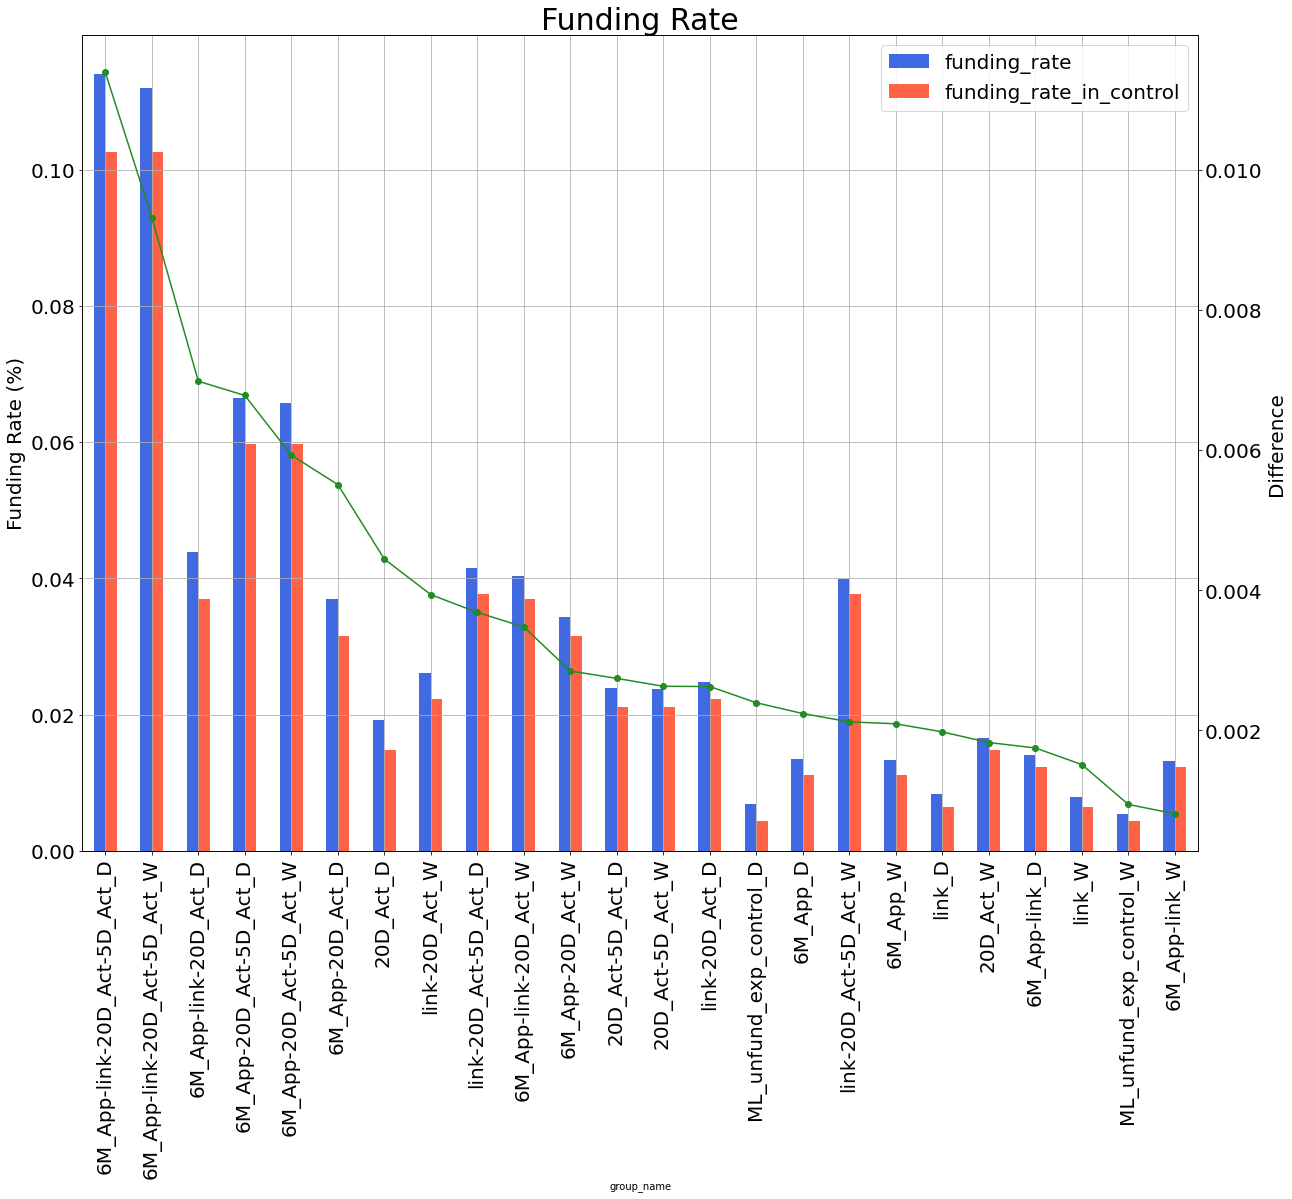

In [39]:
# Plot funding rate for treatment and control groups
sort_fund_diff = merge_contr_treat.sort_values('diff_funding_rate', ascending=False)

ax1 = sort_fund_diff.plot(x="group_name", y=["funding_rate", "funding_rate_in_control"], kind="bar", color=['royalblue', 'tomato'], figsize=(20, 15))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Funding Rate (%)',fontsize=20)
plt.title('Funding Rate',fontsize=30)
plt.legend(fontsize=20)
plt.grid(visible=True, which='both')

ax2=ax1.twinx()
ax2.plot(sort_fund_diff['group_name'], sort_fund_diff['diff_funding_rate'], color="forestgreen",marker="o")

plt.yticks(fontsize=20)
plt.ylabel('Difference',fontsize=20)

plt.show()

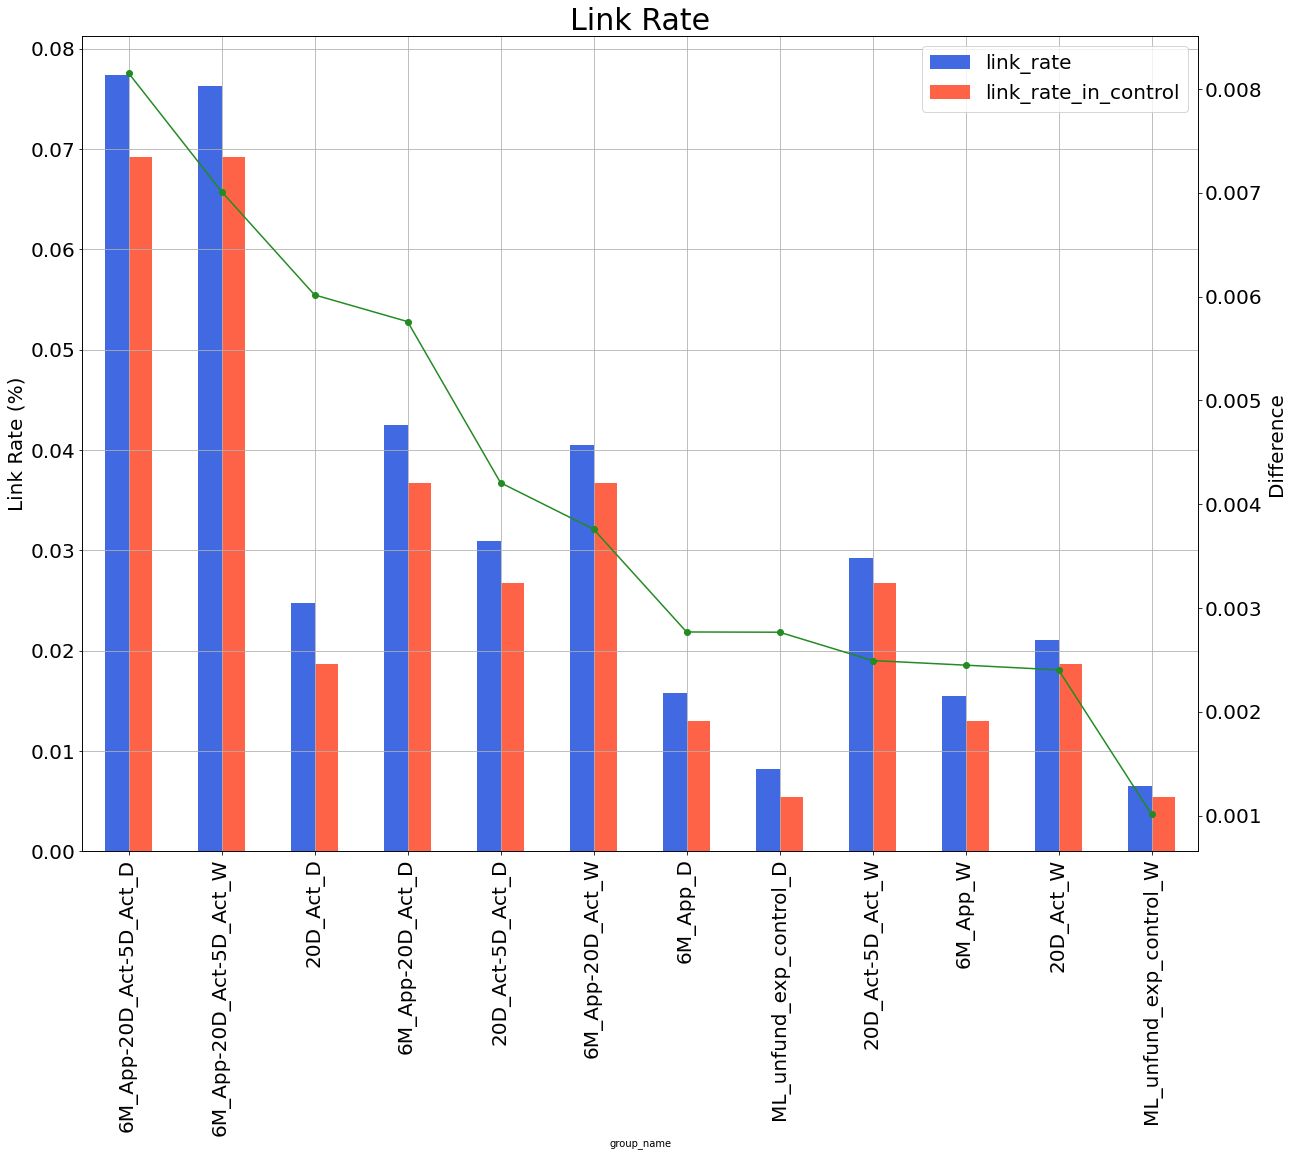

In [40]:
# Plot link rate for treatment and control groups (Remove the link user segments)
sort_link_diff = merge_contr_treat[merge_contr_treat['link_rate_in_control'] != 1].sort_values('diff_link_rate', ascending=False)

ax1 = sort_link_diff.plot(x="group_name", y=["link_rate", "link_rate_in_control"], kind="bar", color=['royalblue', 'tomato'], figsize=(20, 15))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Link Rate (%)',fontsize=20)
plt.title('Link Rate',fontsize=30)
plt.legend(fontsize=20)
plt.grid(visible=True, which='both')

ax2=ax1.twinx()
ax2.plot(sort_link_diff['group_name'], sort_link_diff['diff_link_rate'], color="forestgreen",marker="o")

plt.yticks(fontsize=20)
plt.ylabel('Difference',fontsize=20)

plt.show()

# Time Series Analysis 

In [41]:
# Email delivery status
email_status_df = user_event_df[['user_uuid','group_name']+PO_number_list]
email_status_df = email_status_df.drop(columns = 'group_name')
email_status_df

# Pesent which email type was sent on each day for all users
email_dict = {}
for i in range(len(PO_number_list)):
    email_dict[i] = PO_number_list[i]

email_by_day_df = sample_exp_df.copy()
for i in range(len(PO_number_list)):
    email_by_day_df['order_' + str(i)] = email_by_day_df['order_' + str(i)].map(email_dict)

email_by_day_df

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,id_5040937410148515023,23,6M_App-link-20D_Act-5D_Act_W,ml_user_clustering_emails_fracs,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_explore_the_app_list,ml_funding_is_safe,ml_funding_faq
479996,id_786871754221668715,23,6M_App-link-20D_Act-5D_Act_W,ml_user_clustering_emails_fracs,ml_investing_101,ml_funding_faq,ml_funding_enables_investing,ml_explore_the_app_investing,ml_explore_the_app_list,ml_diversified_portfolio,ml_funding_is_safe,ml_investing_starts_here,ml_picking_an_investment
479997,id_5562306837451033542,23,6M_App-link-20D_Act-5D_Act_W,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_faq,ml_funding_enables_investing,ml_user_clustering_emails_fracs,ml_picking_an_investment,ml_funding_is_safe,ml_investing_starts_here
479998,id_7974070474102470703,23,6M_App-link-20D_Act-5D_Act_W,ml_explore_the_app_list,ml_diversified_portfolio,ml_funding_faq,ml_explore_the_app_investing,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_funding_enables_investing,ml_investing_101,ml_investing_starts_here,ml_picking_an_investment


In [42]:
email_by_day_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs


In [43]:
# Combine the tables of email delivery status and email on each day
email_status_day_df = pd.merge(email_by_day_df, email_status_df, on='user_uuid', how='inner')

# Transform the table to show delivery status on each day for all users
def transform_table(df):    
    output = df[['user_uuid','group_name']]
    for i in range(10):
        output['order_' + str(i)] = df[df['order_'+str(i)]]
    return output


In [44]:
# Run the transformation function (Long running time)
user_email_onday_df = email_status_day_df.apply(transform_table, axis=1)

In [46]:
# Save the file
user_email_onday_df.to_csv('/content/drive/MyDrive/Project/prj1/user_email_onday_df.csv')

In [47]:
user_email_onday_df.head()

,user_uuid,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,delivered,delivered,open,open,open,delivered,delivered
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Count the number of email delivery for each user segment on each day
days = []
for i in range(10):
    days.append('order_' + str(i))

delivered_onday_df = user_email_onday_df.copy()
for i in days:
    delivered_onday_df[i] = delivered_onday_df[i].notnull()
    
delivered_onday_df = delivered_onday_df.groupby('group_name').sum().reset_index()

In [54]:
delivered_onday_df.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,19455,19410,19378,19337,19271,19197,19167,19138,19099,19068
1,20D_Act-5D_Act_W,19441,19345,19319,19280,19259,19207,19181,19138,19121,0
2,20D_Act_D,19324,19265,19205,19149,19089,18959,18928,18901,18866,18835
3,20D_Act_W,19301,19176,19088,19051,19018,18946,18921,18888,18863,0
4,6M_App-20D_Act-5D_Act_D,19526,19462,19409,19364,19316,19202,19173,19156,19125,19100


The experiment is not finished yet, since the emails have not been sent to the user segments with sending email twice a week on the 10th day.

In [55]:
# Count the number of email opened for each user segment on each day
opened_onday_df = user_email_onday_df.copy()
for i in days:
    opened_onday_df[i] = opened_onday_df[i] == 'open'
    
opened_onday_df = opened_onday_df.groupby('group_name').sum().reset_index()

In [56]:
opened_onday_df.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,3341,3694,3608,3425,3467,3364,2902,3405,3311,3543
1,20D_Act-5D_Act_W,3417,3650,3565,3501,3459,3497,3378,3218,2947,0
2,20D_Act_D,3700,3825,3882,3787,3730,3678,3291,3612,3593,3632
3,20D_Act_W,3637,3886,3826,3746,3601,3533,3597,3374,3229,0
4,6M_App-20D_Act-5D_Act_D,3839,3956,3830,3678,3756,3658,3101,3591,3578,3658


In [61]:
# Email open rate for each user segment on each day
open_rate_onday_df = opened_onday_df.copy()
for i in days:
    open_rate_onday_df[i] = opened_onday_df[i] / delivered_onday_df[i]


In [64]:
open_rate_onday_df.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,0.171730,0.190314,0.186191,0.177122,0.179908,0.175236,0.151406,0.177918,0.173360,0.185809
1,20D_Act-5D_Act_W,0.175763,0.188679,0.184533,0.181587,0.179604,0.182069,0.176112,0.168147,0.154124,NaN
2,20D_Act_D,0.191472,0.198547,0.202135,0.197765,0.195400,0.193998,0.173869,0.191101,0.190448,0.192832
3,20D_Act_W,0.188436,0.202649,0.200440,0.196630,0.189347,0.186477,0.190106,0.178632,0.171182,NaN
4,6M_App-20D_Act-5D_Act_D,0.196610,0.203268,0.197331,0.189940,0.194450,0.190501,0.161738,0.187461,0.187085,0.191518


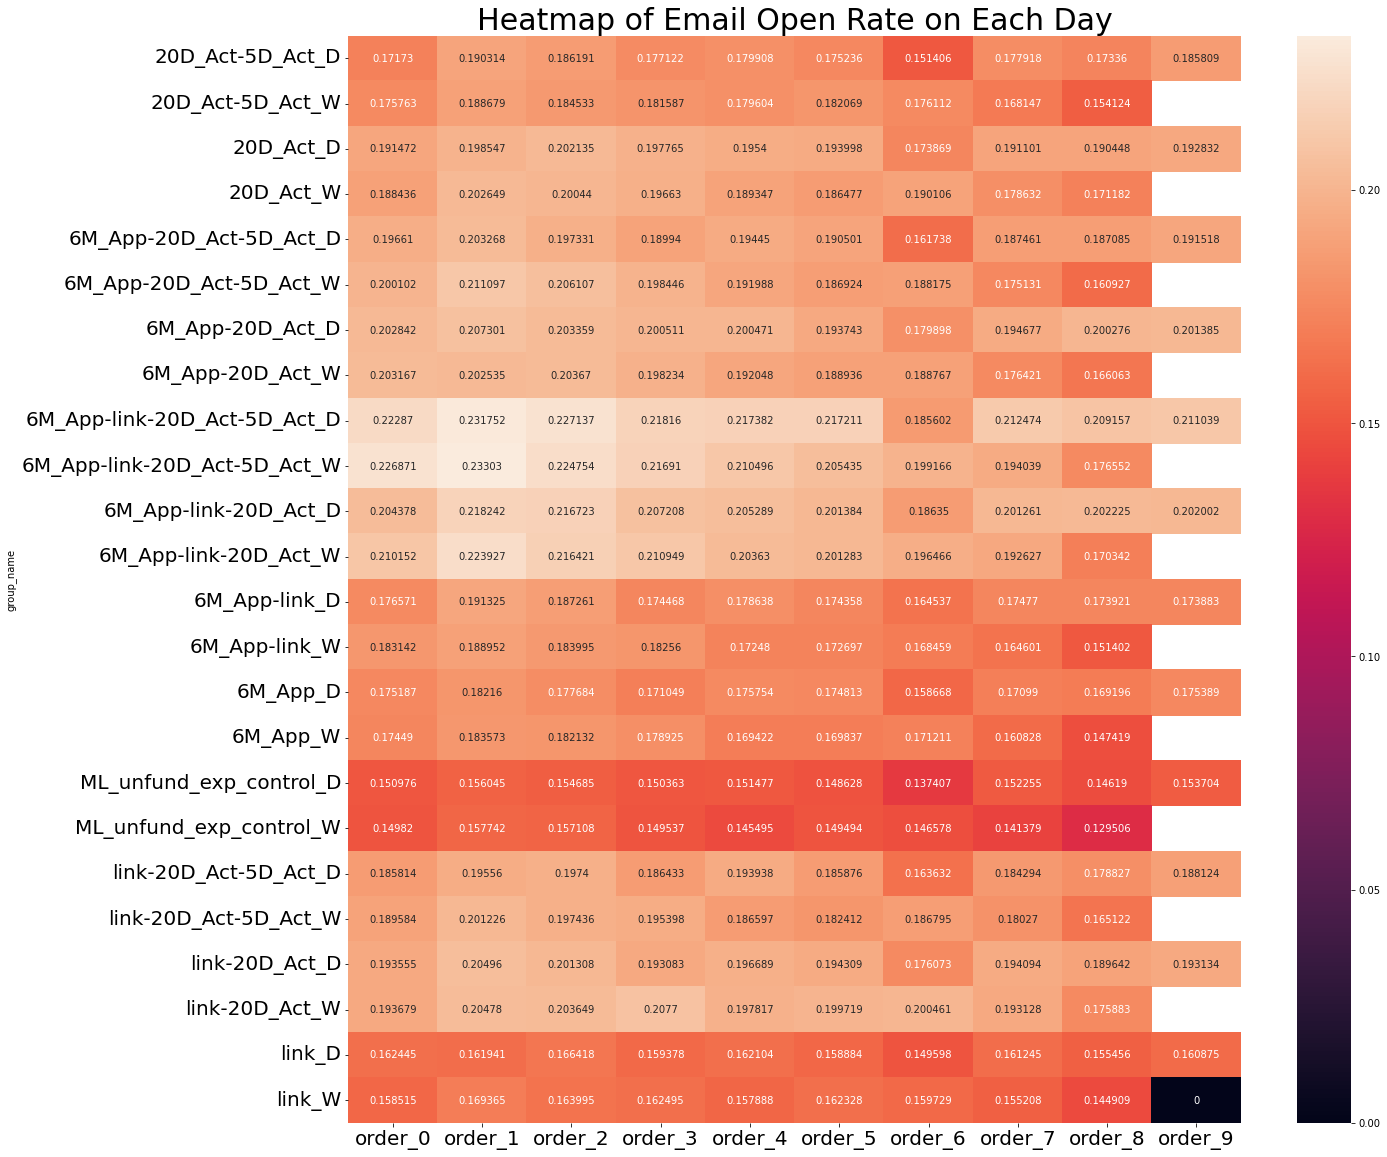

In [66]:
# Heatmap of email open rate
ht_open_rate_onday_df = open_rate_onday_df.set_index('group_name')

fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(ht_open_rate_onday_df, annot=True, fmt='g')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email Open Rate on Each Day', fontsize=30)

plt.show()

# Conclusion

1. From Calculating the metrics for treatment groups, the frequence of sending email does not have much different email open rate for each user segment.  
2. The email tpye 'ml_funding_faq' is most effective one which has highest open rate and highest correlation with open rate, and user segments '6M_App-link-20D_Act-5D_Act' have best performance than other group. Therefore, the email marketing campaign should send more type with 'ml_funding_faq' and pay more attention on the user segment '6M_App-link-20D_Act-5D_Act'.
3. The A/B testing proves that sending email significantly improve users' funding and link rate, so marketing team should keep on that strategy to convert more users.
4. The time series analysis shows that the email open rate is decreased for each user segment with the number of days increases. Therefore, it could be better to send the email to users at the first three days which achieve higher opening rate than later. Besides, the experiment is not finished yet, since some users do not receive the email on the last day.